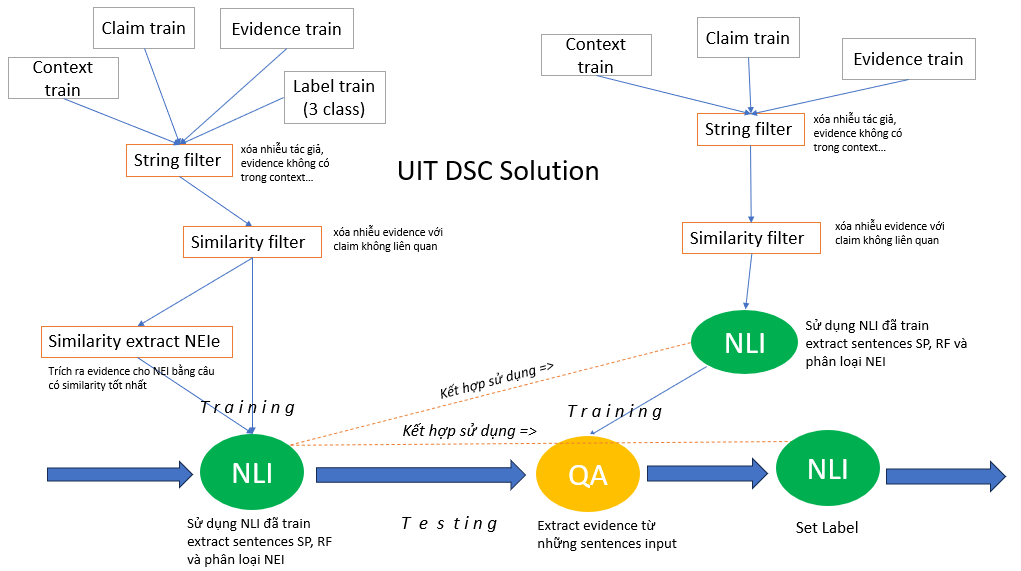

## Import lib

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/uitds-fever-ise-publist-test/ise-dsc01-public-test-offcial.json
/kaggle/input/uitds-fever-ise-publist-test/ise-dsc01-train.json
/kaggle/input/uitds-fever-ise-publist-test/ise-dsc01-train_new.json
/kaggle/input/uitds-fever-ise-publist-test/ISE-Train-Valid-Test/valid.csv
/kaggle/input/uitds-fever-ise-publist-test/ISE-Train-Valid-Test/train.csv
/kaggle/input/uitds-fever-ise-publist-test/ISE-Train-Valid-Test/test.csv
/kaggle/input/uitds-fever-ise-publist-test/ISE-Train-Valid-Test/small_train.csv
/kaggle/input/uitds-fever-ise-publist-test/ISE-Train-Valid-Test/small_train_balance.csv
/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/valid.csv
/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/small_test.csv
/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/small_valid.csv
/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/train.csv
/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/test.csv
/kaggle/input/uitds-fever-ise-publist-tes

In [2]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from tqdm.auto import tqdm

In [3]:
# set random seed
myseed = 6666  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [4]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
import wandb
user_secrets = UserSecretsClient()

my_wandb_secret = user_secrets.get_secret("wandb_api_key")
my_huggingface_secret = user_secrets.get_secret("huggingface-token-write")

wandb.login(key=my_wandb_secret)
login(token = my_huggingface_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Load data

In [5]:
new_train_df = pd.read_csv('/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/small_train.csv')
new_valid_df = pd.read_csv('/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/small_valid.csv')
new_test_df = pd.read_csv('/kaggle/input/uitds-fever-ise-publist-test/New-Balance-Data/small_test.csv')

In [6]:
new_train_df['verdict'].value_counts()

verdict
SUPPORTED    2060
REFUTED      2052
NEI          1963
Name: count, dtype: int64

In [7]:
new_valid_df['verdict'].value_counts()

verdict
REFUTED      266
SUPPORTED    255
NEI          238
Name: count, dtype: int64

In [8]:
new_test_df['verdict'].value_counts()

verdict
REFUTED      261
SUPPORTED    260
NEI          239
Name: count, dtype: int64

## String filter

#### X√≥a `\n` c√°i r·ªìi t√≠nh ti·∫øp:))


In [9]:
def remove_down_line(df):
    df['context'] = df['context'].apply(lambda x: x.replace('\n', ' '))
    df['claim'] = df['claim'].apply(lambda x: x.replace('\n', ' '))
    return df

In [10]:
new_train_df = remove_down_line(new_train_df)
new_valid_df = remove_down_line(new_valid_df)
new_test_df = remove_down_line(new_test_df)

#### Th√™m evidence t·∫°m cho NEI

In [11]:
def processing_evidence(data):
    data['evidence_train'] = ""  # T·∫°o c·ªôt 'evidence_train' tr∆∞·ªõc
    for i in tqdm(range(len(data))):
        if data['verdict'][i] == "NEI":
            data.loc[i, 'evidence_train'] = data['context'][i].split('. ')[0]
        else:
            data.loc[i, 'evidence_train'] = data['evidence'][i]
    return data

In [12]:
train_df = processing_evidence(new_train_df)
valid_df = processing_evidence(new_valid_df)
test_df = processing_evidence(new_test_df)

  0%|          | 0/6075 [00:00<?, ?it/s]

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

In [13]:
def remove_author(df):
    df = df[df['evidence_train'].apply(lambda x: len(x.split()) > 6)]
    return df

df_train = remove_author(train_df)
df_valid = remove_author(valid_df)
df_test = remove_author(test_df)

In [14]:
df_test['verdict'].value_counts()

verdict
REFUTED      261
SUPPORTED    254
NEI          235
Name: count, dtype: int64

In [15]:
df_train['verdict'].value_counts()

verdict
REFUTED      2036
SUPPORTED    2002
NEI          1950
Name: count, dtype: int64

#### Ti·ªÅn x·ª≠ l√Ω d·∫•u

In [16]:
import re

def preprocess_text(text: str) -> str:
    text = re.sub(r"['\"\?:\-!]", "", text)
    
    text = text.replace('\n', ' ')
    
    text = text.strip()
    text = " ".join(text.split())
#     text = text.lower()
    return text

In [17]:
def remove_punctuation_for_dataframe(df):
    df.loc[:, 'context'] = df['context'].apply(preprocess_text)
    df.loc[:, 'claim'] = df['claim'].apply(preprocess_text)
#     df['evidence'] = df['evidence'].apply(preprocess_text)
    df.loc[:, 'evidence_train'] = df['evidence_train'].apply(preprocess_text)
    return df

In [18]:
df_train = remove_punctuation_for_dataframe(df_train)
df_valid = remove_punctuation_for_dataframe(df_valid)
df_test = remove_punctuation_for_dataframe(df_test)

In [19]:
df_train.sample(5)

id                                            context  \
1758  11042  Tr·∫£ l·ªùi B·ªèng n·∫Øng s·∫Ω g√¢y t·ªïn th∆∞∆°ng da vƒ©nh vi...   
4043  30982  B√πi ƒê·ª©c Hi·∫øu, sinh nƒÉm 2005, H·∫£i Ph√≤ng, hi·ªán l...   
3160  10412  S·∫£n ph·∫©m c·ªßa T√¥ ƒêinh H·ªìng Ph√∫c, L·∫°i Hu·ª≥nh Nh·∫•t...   
4756  13330  Ng√†y 24/9, ƒê·ªìn bi√™n ph√≤ng C·ª≠a kh·∫©u c·∫£ng An Th·ªõ...   
5594   8628  S√°ng 11/1, B√πi Duy Nam xin ngh·ªâ ph√©p ƒë·ªÉ v·ªÅ tr∆∞...   

                                                  claim    verdict  \
1758            Kem c√≥ m√†u gi√∫p gi·∫£m thi·ªÉu v√πng b·ªè s√≥t.  SUPPORTED   
4043  ƒê·∫øn nƒÉm l·ªõp 9, ƒê·ª©c Hi·∫øu √¥n thi ƒë·ªÉ xin h·ªçc b·ªïng...  SUPPORTED   
3160  c√¥ng th·ª©c s·ª≠ d·ª•ng ch·∫•t ph·ª• gia ƒë·ªÉ t·∫°o nguy√™n l...  SUPPORTED   
4756  T√†u xu·∫•t b·∫øn ng√†y 119, ƒë·∫øn kho·∫£ng 10h ng√†y 229...  SUPPORTED   
5594  Nam s·∫Ω xin h·ªçc b·ªïng ·ªü n∆∞·ªõc ngo√†i sau khi c√≥ n·ªÅ...  SUPPORTED   

                                               evidence    domain  \
1758  Kem c√≥ m√†u gi√∫p b·∫°n d·ªÖ d√†ng ph√°t hi·ªán v√πng b·ªè ...  suc-khoe   
4043  ƒê·∫øn nƒÉm l·ªõp 9, ƒê·ª©c Hi·∫øu √¥n thi ƒë·ªÉ ·ª©ng tuy·ªÉn h·ªç...  giao-duc   
3160  "ƒêi·ªÅu quan tr·ªçng nh·∫•t trong s·∫£n ph·∫©m n√†y l√† c√¥...  khoa-hoc   
4756  T√†u xu·∫•t ph√°t ng√†y 11/9, ƒë·∫øn kho·∫£ng 10h ng√†y 2...   thoi-su   
5594  Em d·ª± ƒë·ªãnh khi ƒë√£ c√≥ n·ªÅn t·∫£ng nghi√™n c·ª©u v·ªØng ...  giao-duc   

                                         evidence_train  
1758  Kem c√≥ m√†u gi√∫p b·∫°n d·ªÖ d√†ng ph√°t hi·ªán v√πng b·ªè ...  
4043  ƒê·∫øn nƒÉm l·ªõp 9, ƒê·ª©c Hi·∫øu √¥n thi ƒë·ªÉ ·ª©ng tuy·ªÉn h·ªç...  
3160  ƒêi·ªÅu quan tr·ªçng nh·∫•t trong s·∫£n ph·∫©m n√†y l√† c√¥n...  
4756  T√†u xu·∫•t ph√°t ng√†y 11/9, ƒë·∫øn kho·∫£ng 10h ng√†y 2...  
5594  Em d·ª± ƒë·ªãnh khi ƒë√£ c√≥ n·ªÅn t·∫£ng nghi√™n c·ª©u v·ªØng ...

In [20]:
df_test.sample(5)

id                                            context  \
121  26546  Nga t·ª´ l√¢u ƒë√£ l√† nh√† xu·∫•t kh·∫©u v≈© kh√≠ l·ªõn th·ª© ...   
67   34371  Hanami l√† l·ªÖ h·ªôi hoa anh ƒë√†o ·ªü Nh·∫≠t B·∫£n. Ch√∫ng...   
175  19379  ƒê√¢y l√† k·∫øt qu·∫£ c·ªßa d·ª± √°n h·ª£p t√°c c√¥ng t∆∞ Chu·ªói...   
115  30444  T·∫°i d·ª± th·∫£o Lu·∫≠t B·∫£o hi·ªÉm x√£ h·ªôi s·ª≠a ƒë·ªïi ƒëang ...   
442  35216  T·ª´ 27/4, du kh√°ch ƒë·∫øn l√†ng Iselwald kh√¥ng th·ªÉ ...   

                                                 claim    verdict  \
121  Theo gi·ªõi quan s√°t B·∫Øc Kinh hi·ªán ƒëang ng√†y c√†n...    REFUTED   
67   Nh√† s·ª≠ h·ªçc Sergio Hernandez n√≥i r·∫±ng Mexico kh...    REFUTED   
175  N√¥ng d√¢n ƒë∆∞·ª£c h∆∞·ªõng d·∫´n thay ƒë·ªïi c√°c th√≥i quen...  SUPPORTED   
115  ƒêi·ªÅu ki·ªán h∆∞·ªüng lo·∫°i tr·ª£ c·∫•p n√†y l√† ng∆∞·ªùi t·ª´ 6...  SUPPORTED   
442  H·ªì Brienz c√≥ v·ªã tr√≠ ·ªü ph√≠a b·∫Øc d√£y Alps, thu·ªôc...  SUPPORTED   

                                              evidence    domain  \
121  Theo gi·ªõi quan s√°t, Trung Qu·ªëc t·ª´ng ph·ª• thu·ªôc ...  the-gioi   
67   Ch√∫ng t√¥i c≈©ng c√≥ hanami, nh∆∞ng l√† hoa ph∆∞·ª£ng ...  the-gioi   
175  "C√°c ti√™u chu·∫©n SRP h∆∞·ªõng d·∫´n n√¥ng d√¢n thay ƒë·ªï...   thoi-su   
115  ƒêi·ªÅu ki·ªán h∆∞·ªüng lo·∫°i tr·ª£ c·∫•p n√†y l√† ng∆∞·ªùi t·ª´ 6...   thoi-su   
442  H·ªì Brienz n·∫±m ·ªü ph√≠a b·∫Øc c·ªßa d√£y Alps, bang Be...   du-lich   

                                        evidence_train  
121  Theo gi·ªõi quan s√°t, Trung Qu·ªëc t·ª´ng ph·ª• thu·ªôc ...  
67   Ch√∫ng t√¥i c≈©ng c√≥ hanami, nh∆∞ng l√† hoa ph∆∞·ª£ng ...  
175  C√°c ti√™u chu·∫©n SRP h∆∞·ªõng d·∫´n n√¥ng d√¢n thay ƒë·ªïi...  
115  ƒêi·ªÅu ki·ªán h∆∞·ªüng lo·∫°i tr·ª£ c·∫•p n√†y l√† ng∆∞·ªùi t·ª´ 6...  
442  H·ªì Brienz n·∫±m ·ªü ph√≠a b·∫Øc c·ªßa d√£y Alps, bang Be...

#### X√≥a envidence kh√¥ng n·∫±m trong context

**H√†m extract sentence**

In [21]:
def extract_sentences_offcial(context):
    sentences = re.split(r'(?<!PGS)\.\s+(?=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, a, √°, √†, ·∫°, ·∫£, √£, ·∫≠, ·∫•, ·∫ß, ·∫´, ·∫©, √¢, ·∫∑, ·∫Ø, ·∫±, ·∫µ, ·∫≥, ƒÉ, b, c, d, ƒë, e, √©, √®, ·∫π, ·∫ª, ·∫Ω, √™, ·∫ø, ·ªÅ, ·ªá, ·ªÉ, ·ªÖ, f, j, w, z, g, h, i, ·ªã, ·ªâ, √≠, √¨, ƒ©, k, l, m, n, o, √≥, ·ªè, √≤, ·ªç, √µ, √¥, ·ªë, ·ªì, ·ªó, ·ªô, ·ªï, ∆°, ·ªü, ·ª£, ·ªù, ·ªõ, ·ª°, p, q, r, s, t, u, √π, √∫, ·ª•, ·ªß, ≈©, ∆∞, ·ª©, ·ª´, ·ª≠, ·ª±, ·ªØ, v, x, y, ·ª∑, ·ª≥, √Ω, ·ªπ, ·ªµ, A, √Å, √Ä, ·∫†, ·∫¢, √É, ·∫¨, ·∫§, ·∫¶, ·∫™, ·∫®, √Ç, ·∫∂, ·∫Æ, ·∫∞, ·∫¥, ·∫≤, ƒÇ, B, C, D, ƒê, E, √â, √à, ·∫∏, ·∫∫, ·∫º, √ä, ·∫æ, ·ªÄ, ·ªÜ, ·ªÇ, ·ªÑ, F, J, W, Z G, H, I, ·ªä, ·ªà, √ç, √å, ƒ®, K, L, M, N, O, √ì, ·ªé, √í, ·ªå, √ï, √î, ·ªê, ·ªí, ·ªñ, ·ªò, ·ªî, ∆†, ·ªû, ·ª¢, ·ªú, ·ªö, ·ª†, P, Q, R, S, T, U, √ô, √ö, ·ª§, ·ª¶, ≈®, ∆Ø, ·ª®, ·ª™, ·ª¨, ·ª∞, ·ªÆ, V, X, Y, ·ª∂, ·ª≤, √ù, ·ª∏, ·ª¥, \\",‚Äú, \-,*])', context)
    return sentences

In [22]:
import re

def only_word(text: str) -> str:
    text = re.sub(r"['\",\.\?:\-!]", "", text)
    text = text.strip()
    text = " ".join(text.split())
    text = text.lower()
    return text

def check_evidence_noise(context, evidence):
    lst_sentence_in_context = extract_sentences_offcial(context)
    for sentence in lst_sentence_in_context:
        if only_word(sentence) == only_word(evidence):
            return True
    return False
def process_evidence_noise_for_dataframe(df):
    df = df.reset_index()
    df = df.drop(columns = ['index'])
    
    n_print = 2
    n_remove = 0
    
    lst_noise = []
    for i in range(len(df)):
        if check_evidence_noise(df['context'][i], df['evidence_train'][i]) == False:
            if n_print > 0:
                print("\n\n\n==>", df['context'][i],'\n==>' ,df['evidence_train'][i])
                n_print -= 1
                n_remove += 1
            lst_noise.append(i)
    print("‚ö†Ô∏èS·ªë sample ƒë√£ x√≥a:", n_remove)
    df = df.drop(lst_noise)
    return df

In [23]:
df_train['verdict'].value_counts()

verdict
REFUTED      2036
SUPPORTED    2002
NEI          1950
Name: count, dtype: int64

In [24]:
df_train = process_evidence_noise_for_dataframe(df_train)
df_valid = process_evidence_noise_for_dataframe(df_valid)
df_test = process_evidence_noise_for_dataframe(df_test)




==> Ung th∆∞ da th∆∞·ªùng do ti·∫øp x√∫c v·ªõi tia c·ª±c t√≠m (UV) t·ª´ m·∫∑t tr·ªùi trong th·ªùi gian d√†i. Ti·ªÅn s·ª≠ gia ƒë√¨nh m·∫Øc ung th∆∞ da c≈©ng l√†m tƒÉng kh·∫£ nƒÉng m·∫Øc b·ªánh. D∆∞·ªõi ƒë√¢y l√† 9 quan ni·ªám sai l·∫ßm v·ªÅ ung th∆∞ da. Ch·ªâ c√≥ m·ªôt lo·∫°i ung th∆∞ da Theo Hi·ªáp h·ªôi Ung th∆∞ M·ªπ, c√≥ nhi·ªÅu lo·∫°i ung th∆∞ da, trong ƒë√≥ hai lo·∫°i ph·ªï bi·∫øn nh·∫•t l√† ung th∆∞ bi·ªÉu m√¥ t·∫ø b√†o ƒë√°y v√† t·∫ø b√†o v·∫£y. Hai lo·∫°i ung th∆∞ da n√†y b·∫Øt ngu·ªìn t·ª´ l·ªõp ƒë√°y v√† l·ªõp v·∫£y c·ªßa da. Ung th∆∞ h·∫Øc t·ªë √≠t ph·ªï bi·∫øn h∆°n, b·∫Øt ngu·ªìn t·ª´ t·∫ø b√†o h·∫Øc t·ªë t·∫ø b√†o t·∫°o ra s·∫Øc t·ªë c·ªßa da. Kh·ªëi u √°c t√≠nh ch·ªâ l√† m·ªôt n·ªët ru·ªìi ƒê√∫ng l√† h·∫ßu h·∫øt c√°c kh·ªëi u √°c t√≠nh ƒë·ªÅu ph√°t sinh t·ª´ c√°c t·∫ø b√†o h·∫Øc t·ªë, g·ªìm c·∫£ nh·ªØng t·∫ø b√†o ƒë∆∞·ª£c t√¨m th·∫•y trong n·ªët ru·ªìi. Tuy nhi√™n, kh√¥ng ph·∫£i l√† m·ªôt n·ªët ru·ªìi b√¨nh th∆∞·ªùng, ch·ªâ c·∫ßn lo·∫°i b·ªè n·ªët ru·ªìi l√† ngƒÉn ch·∫∑

## Similarity filter (x√≥a nhi·ªÖu evidence v·ªõi claim kh√¥ng li√™n quan v·ªõi Support v√† refute)

·ªû ƒë√¢y t√¥i s·ª≠ d·ª•ng ph∆∞∆°ng ph√°p cosine similarity v·ªõi IF-IDF c·ªßa sklearn,  t√¥i c√≥ nghi√™n c·ª©u m·ªôt s·ªë ph∆∞∆°ng ph√°p ·ªü ƒë√¢y https://www.kaggle.com/code/salmon2/preprocessing-noise-data-with-similarity

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity_with_TF_IDF_Sklearn(claim, evidence):
    
    # T·∫°o m·ªôt TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Bi·ªÉu di·ªÖn c√¢u th√†nh vector TF-IDF
    tfidf_matrix = tfidf_vectorizer.fit_transform([claim, evidence])

    # T√≠nh to√°n cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

    return cosine_sim[0][0]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [26]:
print(df_train.shape)
df_train.head(3)

(5940, 7)


id                                            context  \
0  35012  Trong ng√†y Th·ª© nƒÉm Tu·∫ßn Th√°nh 6/4, Gi√°o ho√†ng ...   
1  22511  Leonardo da Vinci c√≥ th·ªÉ ƒë∆∞·ª£c nh·ªõ t·ªõi nhi·ªÅu nh...   
2  31056  Ph·∫ßn l·ªõn th√≠ sinh d·ª± k·ª≥ thi tuy·ªÉn sinh ƒë·∫°i h·ªçc...   

                                               claim    verdict  \
0  Gi√°o ho√†ng Francis kh√¥ng b·ªã ch·ª©ng ƒëau th·∫ßn kin...    REFUTED   
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...    REFUTED   
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  SUPPORTED   

                                            evidence    domain  \
0  Gi√°o ho√†ng Francis c≈©ng b·ªã ch·ª©ng ƒëau th·∫ßn kinh...  the-gioi   
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...  khoa-hoc   
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  giao-duc   

                                      evidence_train  
0  Gi√°o ho√†ng Francis c≈©ng b·ªã ch·ª©ng ƒëau th·∫ßn kinh...  
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...  
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...

In [27]:
def reset_index_vip(df):
    df = df.reset_index()
    df = df.drop(columns = ['index'])
    return df

In [28]:
df_train = reset_index_vip(df_train)
df_valid = reset_index_vip(df_valid)
df_test = reset_index_vip(df_test)

In [29]:
print(df_train.shape)
df_train.head(3)

(5940, 7)


id                                            context  \
0  35012  Trong ng√†y Th·ª© nƒÉm Tu·∫ßn Th√°nh 6/4, Gi√°o ho√†ng ...   
1  22511  Leonardo da Vinci c√≥ th·ªÉ ƒë∆∞·ª£c nh·ªõ t·ªõi nhi·ªÅu nh...   
2  31056  Ph·∫ßn l·ªõn th√≠ sinh d·ª± k·ª≥ thi tuy·ªÉn sinh ƒë·∫°i h·ªçc...   

                                               claim    verdict  \
0  Gi√°o ho√†ng Francis kh√¥ng b·ªã ch·ª©ng ƒëau th·∫ßn kin...    REFUTED   
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...    REFUTED   
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  SUPPORTED   

                                            evidence    domain  \
0  Gi√°o ho√†ng Francis c≈©ng b·ªã ch·ª©ng ƒëau th·∫ßn kinh...  the-gioi   
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...  khoa-hoc   
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  giao-duc   

                                      evidence_train  
0  Gi√°o ho√†ng Francis c≈©ng b·ªã ch·ª©ng ƒëau th·∫ßn kinh...  
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...  
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...

#### Visulization method

In [30]:
# lst_sp_score_sklearn = []
# lst_rf_score_sklearn = []


# for i in tqdm(range(len(df_train))):
#     if df_train['verdict'][i] == 'NEI':
#         continue
#     claim = df_train['claim'][i]
#     evidence = df_train['evidence_train'][i]
#     sklearn_score = get_similarity_with_TF_IDF_Sklearn(claim, evidence)

#     if df_train['verdict'][i] == 'SUPPORTED':
#         lst_sp_score_sklearn.append((sklearn_score, i))
#     else:
#         lst_rf_score_sklearn.append((sklearn_score, i))

In [31]:
# S·∫Øp x·∫øp danh s√°ch t·ª´ l·ªõn ƒë·∫øn b√© d·ª±a tr√™n gi√° tr·ªã ƒë·∫ßu ti√™n c·ªßa m·ªói ph·∫ßn t·ª≠
# sorted_lst_sp_score_sklearn = sorted(lst_sp_score_sklearn, key=lambda x: x[0], reverse=True)
# sorted_lst_rf_score_sklearn = sorted(lst_rf_score_sklearn, key=lambda x: x[0], reverse=True)

In [32]:
# sorted_lst_sp_score_sklearn[:10]

In [33]:
# cnt = 0
# # for i in range(len(sorted_lst_sp_score_sklearn)-1, -1, -1):
# for i in range(len(sorted_lst_sp_score_sklearn)):

# #     if lst_sp_score_sklearn[i] <= min(lst_sp_score_sklearn):
#     index = sorted_lst_sp_score_sklearn[i][1]
#     score = sorted_lst_sp_score_sklearn[i][0]
#     cnt += 1
#     if cnt == 5:
#         break
#     print(f'------{cnt}------\n')
#     print(f"ID: {df_train['id'][index]}\nClaim: {df_train['claim'][index]}\nEvidence_train: {df_train['evidence_train'][index]}\nScore: {score}")
# #         print(f'-----------------\n')

In [34]:
# cnt = 0
# for i in range(len(sorted_lst_rf_score_sklearn)-1, -1, -1):
# # for i in range(len(sorted_lst_rf_score_sklearn)):

# #     if lst_sp_score_sklearn[i] <= min(lst_sp_score_sklearn):
#     index = sorted_lst_rf_score_sklearn[i][1]
#     score = sorted_lst_rf_score_sklearn[i][0]
#     cnt += 1
#     if cnt == 5:
#         break
#     print(f'------{cnt}------\n')
#     print(f"ID: {df_train['id'][index]}\nClaim: {df_train['claim'][index]}\nEvidence_train: {df_train['evidence_train'][index]}\nScore: {score}")
# #         print(f'-----------------\n')

#### Method

**Support, refute: < 0.06 th√¨ remove / > 0.8 th√¨ l√† evidence**

In [35]:
 def remove_noise_data_with_TF_IDF_sklearn(df):
    
    lst_remove = []
    n_remove = 0
    for i in tqdm(range(len(df))):
        if df['verdict'][i] == 'NEI':
            continue
        claim = df['claim'][i]
        evidence = df['evidence_train'][i]
        sklearn_score = get_similarity_with_TF_IDF_Sklearn(claim, evidence)
        
        if sklearn_score <= 0:
            lst_remove.append(i)
            n_remove += 1
    df = df.drop(lst_remove)
    print("==>üåü S·ªë l∆∞·ª£ng sample ƒë√£ x√≥a: ", n_remove)
    return df

In [36]:
df_train = remove_noise_data_with_TF_IDF_sklearn(df_train)
df_valid = remove_noise_data_with_TF_IDF_sklearn(df_valid)
df_test = remove_noise_data_with_TF_IDF_sklearn(df_test)

  0%|          | 0/5940 [00:00<?, ?it/s]

==>üåü S·ªë l∆∞·ª£ng sample ƒë√£ x√≥a:  7


  0%|          | 0/740 [00:00<?, ?it/s]

==>üåü S·ªë l∆∞·ª£ng sample ƒë√£ x√≥a:  2


  0%|          | 0/747 [00:00<?, ?it/s]

==>üåü S·ªë l∆∞·ª£ng sample ƒë√£ x√≥a:  0


## Similarity extract NEI evidence

#### NEI evidence s·∫Ω l√† c√¢u trong c√≥ context c√≥ ƒëi·ªÉm similarity cao nh·∫•t so v·ªõi claim

In [37]:
print(df_train.shape)
df_train.head()

(5933, 7)


id                                            context  \
0  35012  Trong ng√†y Th·ª© nƒÉm Tu·∫ßn Th√°nh 6/4, Gi√°o ho√†ng ...   
1  22511  Leonardo da Vinci c√≥ th·ªÉ ƒë∆∞·ª£c nh·ªõ t·ªõi nhi·ªÅu nh...   
2  31056  Ph·∫ßn l·ªõn th√≠ sinh d·ª± k·ª≥ thi tuy·ªÉn sinh ƒë·∫°i h·ªçc...   
3   5167  C·∫ßu ƒëi b·ªô d√†i kho·∫£ng 20 m, r·ªông 4 m, cao h∆°n 5...   
4  13036  Ng√†y 4/3, Ch√≠nh ph·ªß ban h√†nh Ngh·ªã quy·∫øt 30/202...   

                                               claim    verdict  \
0  Gi√°o ho√†ng Francis kh√¥ng b·ªã ch·ª©ng ƒëau th·∫ßn kin...    REFUTED   
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...    REFUTED   
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  SUPPORTED   
3  C·∫ßu ƒëi b·ªô sau khi b·ªã ph√° d·ª° s·∫Ω ƒë∆∞·ª£c d·ª± ki·∫øn x√¢...        NEI   
4  T√≠nh nƒÉng k·ªπ thu·∫≠t, nhu c·∫ßu s·ª≠ d·ª•ng, kh·∫£ nƒÉng ...  SUPPORTED   

                                            evidence    domain  \
0  Gi√°o ho√†ng Francis c≈©ng b·ªã ch·ª©ng ƒëau th·∫ßn kinh...  the-gioi   
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...  khoa-hoc   
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  giao-duc   
3                                                NaN   thoi-su   
4  Gi√° g√≥i th·∫ßu ƒë∆∞·ª£c x√°c ƒë·ªãnh d·ª±a tr√™n t√≠nh nƒÉng ...   thoi-su   

                                      evidence_train  
0  Gi√°o ho√†ng Francis c≈©ng b·ªã ch·ª©ng ƒëau th·∫ßn kinh...  
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...  
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  
3  C·∫ßu ƒëi b·ªô d√†i kho·∫£ng 20 m, r·ªông 4 m, cao h∆°n 5...  
4  Gi√° g√≥i th·∫ßu ƒë∆∞·ª£c x√°c ƒë·ªãnh d·ª±a tr√™n t√≠nh nƒÉng ...

In [38]:
def get_nei_evidence_with_similarity_TF_IDF_sklearn(df):
    df = reset_index_vip(df)
    
    for i in tqdm(range(len(df))):
        if df['verdict'][i] == 'NEI':
            context = df['context'][i]
            claim = df['claim'][i]

            lst_sentences_context = extract_sentences_offcial(context)
            best_score = -1
            for sentence in lst_sentences_context:
                current_score = get_similarity_with_TF_IDF_Sklearn(claim, sentence)
                if current_score > best_score:
                    df.loc[i, 'evidence_train'] = sentence
                    best_score = current_score
    return df

In [39]:
df_train = get_nei_evidence_with_similarity_TF_IDF_sklearn(df_train)
df_valid = get_nei_evidence_with_similarity_TF_IDF_sklearn(df_valid)
df_test = get_nei_evidence_with_similarity_TF_IDF_sklearn(df_test)

  0%|          | 0/5933 [00:00<?, ?it/s]

  0%|          | 0/738 [00:00<?, ?it/s]

  0%|          | 0/747 [00:00<?, ?it/s]

In [40]:
df_train = reset_index_vip(df_train)
df_valid = reset_index_vip(df_valid)
df_test = reset_index_vip(df_test)

#### Ki·ªÉm tra l·∫°i d·ªØ li·ªáu

In [41]:
def df_info(df):
    print(df.shape)
    print(df['verdict'].value_counts())

In [42]:
df_info(df_train)
df_train.head(5)

(5933, 7)
verdict
REFUTED      2001
SUPPORTED    1983
NEI          1949
Name: count, dtype: int64


id                                            context  \
0  35012  Trong ng√†y Th·ª© nƒÉm Tu·∫ßn Th√°nh 6/4, Gi√°o ho√†ng ...   
1  22511  Leonardo da Vinci c√≥ th·ªÉ ƒë∆∞·ª£c nh·ªõ t·ªõi nhi·ªÅu nh...   
2  31056  Ph·∫ßn l·ªõn th√≠ sinh d·ª± k·ª≥ thi tuy·ªÉn sinh ƒë·∫°i h·ªçc...   
3   5167  C·∫ßu ƒëi b·ªô d√†i kho·∫£ng 20 m, r·ªông 4 m, cao h∆°n 5...   
4  13036  Ng√†y 4/3, Ch√≠nh ph·ªß ban h√†nh Ngh·ªã quy·∫øt 30/202...   

                                               claim    verdict  \
0  Gi√°o ho√†ng Francis kh√¥ng b·ªã ch·ª©ng ƒëau th·∫ßn kin...    REFUTED   
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...    REFUTED   
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  SUPPORTED   
3  C·∫ßu ƒëi b·ªô sau khi b·ªã ph√° d·ª° s·∫Ω ƒë∆∞·ª£c d·ª± ki·∫øn x√¢...        NEI   
4  T√≠nh nƒÉng k·ªπ thu·∫≠t, nhu c·∫ßu s·ª≠ d·ª•ng, kh·∫£ nƒÉng ...  SUPPORTED   

                                            evidence    domain  \
0  Gi√°o ho√†ng Francis c≈©ng b·ªã ch·ª©ng ƒëau th·∫ßn kinh...  the-gioi   
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...  khoa-hoc   
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  giao-duc   
3                                                NaN   thoi-su   
4  Gi√° g√≥i th·∫ßu ƒë∆∞·ª£c x√°c ƒë·ªãnh d·ª±a tr√™n t√≠nh nƒÉng ...   thoi-su   

                                      evidence_train  
0  Gi√°o ho√†ng Francis c≈©ng b·ªã ch·ª©ng ƒëau th·∫ßn kinh...  
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...  
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  
3  Sau khi c√°c h·∫°ng m·ª•c t·∫°i khu v·ª±c n√†y ho√†n th√†n...  
4  Gi√° g√≥i th·∫ßu ƒë∆∞·ª£c x√°c ƒë·ªãnh d·ª±a tr√™n t√≠nh nƒÉng ...

In [43]:
df_info(df_valid)
df_valid.head(5)

(738, 7)
verdict
REFUTED      255
SUPPORTED    247
NEI          236
Name: count, dtype: int64


id                                            context  \
0  12194  C∆° quan c√¥ng t·ªë Ai C·∫≠p ng√†y 26/7 g·ª≠i th√¥ng b√°o...   
1  13295  Ng√†y 14/11, √¥ng L∆∞u Trung Nghƒ©a, Gi√°m ƒë·ªëc S·ªü N...   
2   8274  Em nƒÉm nay l·ªõp 12, chu·∫©n b·ªã b∆∞·ªõc v√†o k·ª≥ tuy·ªÉn ...   
3  34313  Khi h·ªç v√†o trong hang ti·∫øp c·∫≠n t√¥i, t√¥i ƒëang n...   
4  32736  C·ª•m n√∫i l·ª≠a Ijen ·ªü ƒê√¥ng Java, Indonesia, tr·∫£i ...   

                                               claim    verdict  \
0  C∆° quan c√¥ng t·ªë Ai C·∫≠p ph·ªëi h·ª£p v·ªõi ƒë·∫°i s·ª© qu√°...  SUPPORTED   
1  Ng√†y 1411, √¥ng L∆∞u Trung Nghƒ©a, Gi√°m ƒë·ªëc S·ªü NN...  SUPPORTED   
2         L√† h·ªçc sinh l·ªõp 12, em s·∫Øp thi t·ªët nghi·ªáp.  SUPPORTED   
3  Trong 400 ng√†y, b√† t·∫≠p th·ªÉ d·ª•c, v·∫Ω tranh v√† ƒëa...    REFUTED   
4  c√≥ r·∫•t nhi·ªÅu ƒë·ªãa ƒëi·ªÉm c√≥ c√°c ng·ªçn l·ª≠a xanh (d√≤...    REFUTED   

                                            evidence    domain  \
0  C∆° quan c√¥ng t·ªë Ai C·∫≠p ng√†y 26/7 g·ª≠i th√¥ng b√°o...  the-gioi   
1  Ng√†y 14/11, √¥ng L∆∞u Trung Nghƒ©a, Gi√°m ƒë·ªëc S·ªü N...   thoi-su   
2  Em nƒÉm nay l·ªõp 12, chu·∫©n b·ªã b∆∞·ªõc v√†o k·ª≥ tuy·ªÉn ...  giao-duc   
3  Trong 500 ng√†y, b√† t·∫≠p th·ªÉ d·ª•c, v·∫Ω tranh v√† ƒëa...  the-gioi   
4  Kawah Ijen ƒë∆∞·ª£c cho l√† ƒë·ªãa ƒëi·ªÉm duy nh·∫•t tr√™n ...  khoa-hoc   

                                      evidence_train  
0  C∆° quan c√¥ng t·ªë Ai C·∫≠p ng√†y 26/7 g·ª≠i th√¥ng b√°o...  
1  Ng√†y 14/11, √¥ng L∆∞u Trung Nghƒ©a, Gi√°m ƒë·ªëc S·ªü N...  
2  Em nƒÉm nay l·ªõp 12, chu·∫©n b·ªã b∆∞·ªõc v√†o k·ª≥ tuy·ªÉn ...  
3  Trong 500 ng√†y, b√† t·∫≠p th·ªÉ d·ª•c, v·∫Ω tranh v√† ƒëa...  
4  Kawah Ijen ƒë∆∞·ª£c cho l√† ƒë·ªãa ƒëi·ªÉm duy nh·∫•t tr√™n ...

In [44]:
df_info(df_test)
df_test.head(5)

(747, 7)
verdict
REFUTED      259
SUPPORTED    253
NEI          235
Name: count, dtype: int64


id                                            context  \
0  32838  Ch√∫ng t√¥i ƒë√£ t·∫°o ra thi·∫øt b·ªã c√≥ th·ªÉ nh·∫£y cao h...   
1  25999  Chi·ªÅu 10/4, VƒÉn ph√≤ng Ch√≠nh ph·ªß th√¥ng b√°o ch·ªâ ...   
2  13607  Lo·∫°t ·∫£nh m·ªõi nh·∫•t c·ªßa Eugene thu h√∫t h√†ng trƒÉm...   
3   2695  T·ª´ ti·ªÉu h·ªçc, Huy ƒë√£ ti·∫øp c·∫≠n game n√†y tr√™n ƒëi·ªá...   
4   7901  Vi·ªán C√¥ng ngh·ªá L∆∞·ª£ng t·ª≠ T·∫ø Nam v√† ƒê·∫°i h·ªçc Khoa...   

                                               claim    verdict  \
0  nh√≥m nghi√™n c·ª©u cho bi·∫øt, h·ªç ƒë√£ t·∫°o ra thi·∫øt b...    REFUTED   
1  Chi·ªÅu 4/10, VƒÉn ph√≤ng Ch√≠nh ph·ªß th√¥ng b√°o ch·ªâ ...    REFUTED   
2  v√¨ v·∫ª ƒë·∫πp t·ª± nhi√™n c·ªßa c√¥ n√™n ngay khi v·ª´a m·ªõi...  SUPPORTED   
3  T√¥i h·ªçc c√πng v·ªõi con, ƒë√¥i khi h·ªèi con ch·ªó n√†y ...        NEI   
4  C√°c nh√† khoa h·ªçc ƒëang nghi√™n c·ª©u v·ªÅ vi·ªác thay ...  SUPPORTED   

                                            evidence    domain  \
0  "Ch√∫ng t√¥i ƒë√£ t·∫°o ra thi·∫øt b·ªã c√≥ th·ªÉ nh·∫£y cao ...  khoa-hoc   
1  Chi·ªÅu 10/4, VƒÉn ph√≤ng Ch√≠nh ph·ªß th√¥ng b√°o ch·ªâ ...   thoi-su   
2  Ngay t·ª´ khi m·ªõi ra m·∫Øt, c√¥ ƒë∆∞·ª£c nhi·ªÅu ng∆∞·ªùi y√™...   du-lich   
3                                                NaN  giao-duc   
4  Vi·ªác √°p d·ª•ng h·∫°t photon thay th·∫ø h·∫°t ƒëi·ªán t·ª≠ c...  khoa-hoc   

                                      evidence_train  
0  Ch√∫ng t√¥i ƒë√£ t·∫°o ra thi·∫øt b·ªã c√≥ th·ªÉ nh·∫£y cao h...  
1  Chi·ªÅu 10/4, VƒÉn ph√≤ng Ch√≠nh ph·ªß th√¥ng b√°o ch·ªâ ...  
2  Ngay t·ª´ khi m·ªõi ra m·∫Øt, c√¥ ƒë∆∞·ª£c nhi·ªÅu ng∆∞·ªùi y√™...  
3  T√¥i ch∆°i game v·ªõi con, ƒë√¥i khi h·ªèi con ch·ªó n√†y...  
4  Vi·ªác √°p d·ª•ng h·∫°t photon thay th·∫ø h·∫°t ƒëi·ªán t·ª≠ c...

## Chu·∫©n b·ªã d·ªØ li·ªáu

In [45]:
name2Num = {"REFUTED":0,"SUPPORTED":1, "NEI": 2} # Chuy·ªÉn c√°c nh√£n v·ªÅ s·ªë nguy√™n
context_len = []
class SNLIDataSet(Dataset):
    '''
    ƒë·ªãnh nghƒ©a c·ªßa l·ªõp SNLIDataSet, m·ªôt l·ªõp con c·ªßa l·ªõp Dataset trong PyTorch. 
    L·ªõp n√†y s·∫Ω ƒë∆∞·ª£c s·ª≠ d·ª•ng ƒë·ªÉ t·∫°o m·ªôt ƒë·ªëi t∆∞·ª£ng t·∫≠p d·ªØ li·ªáu cho vi·ªác hu·∫•n luy·ªán v√† ki·ªÉm tra m√¥ h√¨nh.
    '''
    def __init__(self,data):
        self.df = data.loc[:, ['verdict', 'claim', 'evidence_train']] # Ch·ªâ ƒë·ªçc 3 c·ªôt quan tr·ªçng
#         self.df['evidence_train'] = self.df['evidence_train'].apply(preprocessing_text)
#         self.df['claim'] = self.df['claim'].apply(preprocessing_text)
        
        print('------ Start -----')
        print(self.df.head())
        self.df = self.df[self.df["verdict"] != "-"] # Lo·∫°i b·ªè c√°c nh√£n kh√¥ng ph√π h·ª£p
#         self.df.dropna()

        # Lo·∫°i b·ªè c√°c d√≤ng c√≥ gi√° tr·ªã null (None) trong c√°c c·ªôt "sentence1" v√† "sentence2" 
        self.df = self.df[self.df["claim"].notnull()]
        self.df = self.df[self.df["evidence_train"].notnull()]
        self.pairs = self.df.values.tolist()
        print(self.pairs[:3])
        print('------ End ----')
#         for text in self.df['claim']:
#             context_len.append(text)
        for text in self.df['evidence_train']:
            context_len.append(text)

    def __len__(self):
        ''' Tr·∫£ v·ªÅ s·ªë l∆∞·ª£ng c·ªßa d·ªØ li·ªáu '''
        return len(self.pairs)

    def __getitem__(self, id):
        ''' L·∫•y d·ªØ li·ªáu theo id '''
        label = name2Num[self.pairs[id][0]]
        text1, text2 = self.pairs[id][1], self.pairs[id][2]
        return text1, text2, label

In [46]:
trainDataset = SNLIDataSet(df_train)
validDataset = SNLIDataSet(df_valid)
testDataset = SNLIDataSet(df_test)


# T·∫°o c√°c dataloader v·ªõi batch_size v√† shuffle d√πng ƒë·ªÉ x√°o tr·ªôn d·ªØ li·ªáu

trainDataLoader = DataLoader(trainDataset,batch_size = 32, shuffle = True)
validDataLoader = DataLoader(validDataset,batch_size = 32, shuffle = True)
testDataLoader = DataLoader(testDataset,batch_size = 32, shuffle = True)

------ Start -----
     verdict                                              claim  \
0    REFUTED  Gi√°o ho√†ng Francis kh√¥ng b·ªã ch·ª©ng ƒëau th·∫ßn kin...   
1    REFUTED  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...   
2  SUPPORTED  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...   
3        NEI  C·∫ßu ƒëi b·ªô sau khi b·ªã ph√° d·ª° s·∫Ω ƒë∆∞·ª£c d·ª± ki·∫øn x√¢...   
4  SUPPORTED  T√≠nh nƒÉng k·ªπ thu·∫≠t, nhu c·∫ßu s·ª≠ d·ª•ng, kh·∫£ nƒÉng ...   

                                      evidence_train  
0  Gi√°o ho√†ng Francis c≈©ng b·ªã ch·ª©ng ƒëau th·∫ßn kinh...  
1  Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn ...  
2  Liang cho bi·∫øt m·ª•c ti√™u c·ªßa anh trong nƒÉm nay ...  
3  Sau khi c√°c h·∫°ng m·ª•c t·∫°i khu v·ª±c n√†y ho√†n th√†n...  
4  Gi√° g√≥i th·∫ßu ƒë∆∞·ª£c x√°c ƒë·ªãnh d·ª±a tr√™n t√≠nh nƒÉng ...  
[['REFUTED', 'Gi√°o ho√†ng Francis kh√¥ng b·ªã ch·ª©ng ƒëau th·∫ßn kinh t·ªça.', 'Gi√°o ho√†ng Francis c≈©ng b·ªã

In [47]:
print(len(trainDataset))
print(len(validDataset))
print(len(testDataset))

5933
738
747


In [48]:
trainDataset[1]

('Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn c∆° th·ªÉ v·ªõi b·ªô ph·∫≠n kh√°c trong ghi ch√©p ph√≠a tr√™n h√¨nh v·∫Ω.',
 'Leonardo t√≥m t·∫Øt t·ª∑ l·ªá t∆∞∆°ng ·ª©ng c·ªßa m·ªói ph·∫ßn c∆° th·ªÉ v·ªõi b·ªô ph·∫≠n kh√°c trong ghi ch√©p ph√≠a d∆∞·ªõi h√¨nh v·∫Ω',
 0)

## Training

In [49]:
from transformers import AutoModelForSequenceClassification, BertTokenizer
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from transformers import get_scheduler
from torch.optim import AdamW

# S·ª≠ d·ª•ng m√¥ h√¨nh BERT ti·∫øng Vi·ªát
# model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3, problem_type="single_label_classification")

# S·ª≠ d·ª•ng tokenizer BERT ti·∫øng Vi·ªát
# tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

'''
2 class



tokenizer = AutoTokenizer.from_pretrained('bkai-foundation-models/vietnamese-bi-encoder')
model = AutoModelForSequenceClassification.from_pretrained('bkai-foundation-models/vietnamese-bi-encoder')
'''

'''3 class'''

# T·∫°o m√¥ h√¨nh m·ªõi v·ªõi s·ªë l·ªõp ƒë·∫ßu ra l√† 3
tokenizer = AutoTokenizer.from_pretrained('bkai-foundation-models/vietnamese-bi-encoder')
model = AutoModelForSequenceClassification.from_pretrained('bkai-foundation-models/vietnamese-bi-encoder', num_labels=3)

# Sao ch√©p tr·ªçng s·ªë t·ª´ m√¥ h√¨nh c≈© sang m√¥ h√¨nh m·ªõi (tr·ª´ l·ªõp cu·ªëi c√πng)
# model.classifier.load_state_dict(model.classifier.state_dict())

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bkai-foundation-models/vietnamese-bi-encoder and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
from transformers import logging
logging.set_verbosity_error()

n_epochs = 10
best_acc = 0
max_length = 200
training_steps = len(trainDataLoader) * n_epochs
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = AdamW(model.parameters(), lr=1e-5)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=training_steps
)
model.to(device)

train_losses, valid_losses = [], []
print("H√£y l√†m m·ªôt c·ªëc c√† ph√™ v√† chillüçµ")
for epoch in range(n_epochs):
    print(f"\n\n========‚öíÔ∏è Train | {epoch + 1:03d}/{n_epochs:03d}========")
    model.train()
    train_acc, train_loss = [], []
    for sentences1, sentences2, labels in tqdm(trainDataLoader):
        encoded_input = tokenizer(sentences2, sentences1, padding="max_length", truncation=True, return_tensors='pt', max_length=max_length)
        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)
        labels = torch.LongTensor(labels).to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = torch.nn.functional.cross_entropy(logits, labels)
        train_loss.append(loss.item())
        
        accuracy = (logits.argmax(dim=-1) == labels).float().mean()
        train_acc.append(accuracy.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
    
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_acc) / len(train_acc)
    print(f"Loss= {train_loss:.4f}, Train acc= {train_acc:.4f}\n")
    train_losses.append(train_loss)
    
    print(f"üìä Valid")
    model.eval()
    valid_loss, valid_acc = [], []
    
    for sentences1, sentences2, labels in tqdm(validDataLoader):
        encoded_input = tokenizer(sentences2, sentences1, padding="max_length", truncation=True, return_tensors='pt', max_length=max_length)
        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)
        labels = torch.LongTensor(labels).to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = torch.nn.functional.cross_entropy(logits, labels)
            valid_loss.append(loss.item())
            
            accuracy = (logits.argmax(dim=-1) == labels).float().mean()
            valid_acc.append(accuracy.item())
    
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_acc) / len(valid_acc)
    print(f"Loss= {valid_loss:.4f}‚ú®, Acc= {valid_acc:.4f}‚ú®")
    valid_losses.append(valid_loss)
    
    if valid_acc > best_acc:
        print(f"üòÆ Best model found at epoch {epoch} -> BEST ({valid_acc:.5f})üèÜ")
#         print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} ")
        best_acc = valid_acc
        model.save_pretrained("./best_clean_model_NLI_vietnameseBE")
        print("Done save‚úîÔ∏è\n")

H√£y l√†m m·ªôt c·ªëc c√† ph√™ v√† chillüçµ


========‚öíÔ∏è Train | 001/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.8935, Train acc= 0.6043

üìä Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.6216‚ú®, Acc= 0.7656‚ú®
üòÆ Best model found at epoch 0 -> BEST (0.76562)üèÜ
Done save‚úîÔ∏è



========‚öíÔ∏è Train | 002/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.5515, Train acc= 0.7941

üìä Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5231‚ú®, Acc= 0.7956‚ú®
üòÆ Best model found at epoch 1 -> BEST (0.79557)üèÜ
Done save‚úîÔ∏è



========‚öíÔ∏è Train | 003/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.3753, Train acc= 0.8688

üìä Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5899‚ú®, Acc= 0.7878‚ú®


========‚öíÔ∏è Train | 004/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.2697, Train acc= 0.9110

üìä Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5093‚ú®, Acc= 0.8190‚ú®
üòÆ Best model found at epoch 3 -> BEST (0.81901)üèÜ
Done save‚úîÔ∏è



========‚öíÔ∏è Train | 005/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.2007, Train acc= 0.9342

üìä Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5386‚ú®, Acc= 0.8151‚ú®


========‚öíÔ∏è Train | 006/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.1364, Train acc= 0.9614

üìä Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.6586‚ú®, Acc= 0.7891‚ú®


========‚öíÔ∏è Train | 007/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.1072, Train acc= 0.9699

üìä Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5822‚ú®, Acc= 0.8151‚ú®


========‚öíÔ∏è Train | 008/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.0879, Train acc= 0.9761

üìä Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5706‚ú®, Acc= 0.8411‚ú®
üòÆ Best model found at epoch 7 -> BEST (0.84115)üèÜ
Done save‚úîÔ∏è



========‚öíÔ∏è Train | 009/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.0716, Train acc= 0.9819

üìä Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5996‚ú®, Acc= 0.8359‚ú®


========‚öíÔ∏è Train | 010/010========


  0%|          | 0/186 [00:00<?, ?it/s]

Loss= 0.0641, Train acc= 0.9835

üìä Valid


  0%|          | 0/24 [00:00<?, ?it/s]

Loss= 0.5992‚ú®, Acc= 0.8385‚ú®


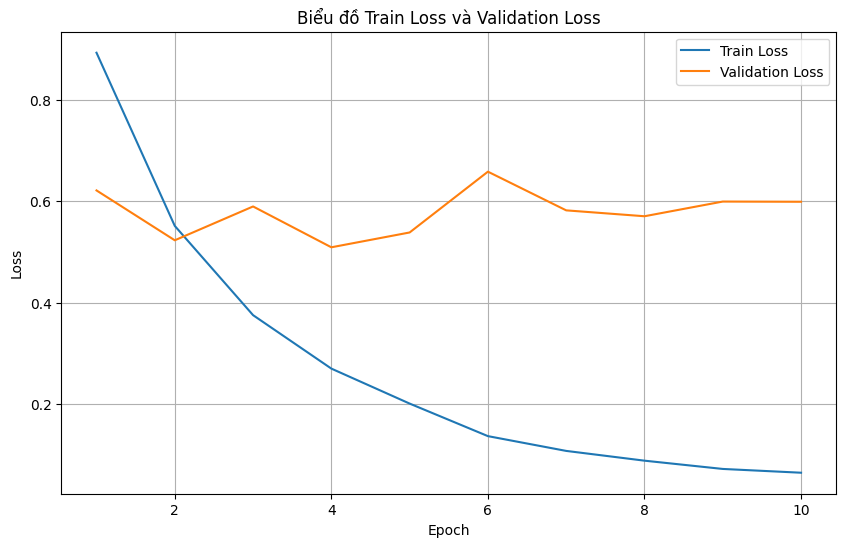

In [51]:
import matplotlib.pyplot as plt

# Tr√≠ch xu·∫•t gi√° tr·ªã th·ª±c t·ª´ c√°c tensor v√† chuy·ªÉn th√†nh danh s√°ch
train_losses_values = [loss for loss in train_losses]
valid_losses_values = [loss for loss in valid_losses]

# T·∫°o m·ªôt danh s√°ch c√°c epoch t∆∞∆°ng ·ª©ng v·ªõi train_losses v√† valid_losses
epochs = list(range(1, len(train_losses_values) + 1))
# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses_values, label='Train Loss')
plt.plot(epochs, valid_losses_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bi·ªÉu ƒë·ªì Train Loss v√† Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evalute

In [52]:
model = AutoModelForSequenceClassification.from_pretrained("./best_clean_model_NLI_vietnameseBE")
model.to(device)
model.eval()
test_acc = []

for sentences1, sentences2, labels in tqdm(testDataLoader):
    encoded_input  = tokenizer(sentences2, sentences1, max_length = max_length, padding="max_length", truncation=True,return_tensors='pt')
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)
    token_type_ids  = encoded_input['token_type_ids'].to(device)    
    labels = torch.LongTensor(labels).to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids, labels = labels)
        accuracy = (outputs.logits.argmax(dim=-1) == labels.to(device)).float().mean()
        test_acc.append(accuracy)

test_acc = sum(test_acc) / len(test_acc)
test_acc *= 100
print(f"\n\n üîéThe accuracy of model in test dataset is: {test_acc:.5f}%")
if test_acc > 94.5140:
    print("====== Model said: ======")
    print("Model saild: Th·∫≠t tuy·ªát v·ªùi!, acc c·ªßa b·∫°n ƒëang l·ªõn h∆°n team top 1 UIT (94.5140%) NH∆ØNG:")
    print("- B·∫°n c√≥ ch·∫Øc m√¨nh tr√≠ch evidence ƒë·ªß ch√≠nh x√°c:))")
    print('\n"Khi b·∫°n khao kh√°t m·ªôt ƒëi·ªÅu g√¨ ƒë√≥, c·∫£ v≈© tr·ª• s·∫Ω h·ª£p l·ª±c gi√∫p b·∫°n ƒë·∫°t ƒë∆∞·ª£c ƒëi·ªÅu ƒë√≥"\n')
    print("H√£y c·ªë g·∫Øng h∆°n nh√≥eüòù")

  0%|          | 0/24 [00:00<?, ?it/s]



 üîéThe accuracy of model in test dataset is: 84.25662%


Acc C≈© b·ªã l·ªói ch∆∞a l∆∞u: 89.29094%

## Test Predict

In [53]:
# Chu·∫©n b·ªã hai c√¢u c·∫ßn d·ª± ƒëo√°n
sentence1 = "Sau 2 ng√†y, b·∫°n s·∫Ω nh·∫≠n ƒë∆∞·ª£c visa ƒëi·ªán t·ª≠ g·ª≠i qua email."
sentence2 = "b·∫°n s·∫Ω nh·∫≠n ƒë∆∞·ª£c visa ƒëi·ªán t·ª≠ g·ª≠i qua email trong 2 ng√†y t·ªõi."

# M√£ h√≥a c√¢u 1 v√† c√¢u 2 b·∫±ng tokenizer
'''N·∫øu d√πng VNcoreNLP'''
# encoded_input = tokenizer(preprocessing_text(sentence1), preprocessing_text(sentence2), max_length=max_length, padding="max_length", truncation=True, return_tensors='pt')
'''N·∫øu kh√¥ng d√πng VNcoreNLP'''
encoded_input = tokenizer(sentence2, sentence1, max_length=max_length, padding="max_length", truncation=True, return_tensors='pt')

# Chuy·ªÉn tensor m√£ h√≥a l√™n thi·∫øt b·ªã (GPU ho·∫∑c CPU)
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)
token_type_ids = encoded_input['token_type_ids'].to(device)

# S·ª≠ d·ª•ng m√¥ h√¨nh ƒë·ªÉ d·ª± ƒëo√°n nh√£n
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    predicted_label = outputs.logits.argmax(dim=-1)

# K·∫øt qu·∫£ d·ª± ƒëo√°n l√† predicted_label
print(f"Predicted label: {predicted_label.item()}")

Predicted label: 1


In [54]:
import torch
import torch.nn.functional as F

# Chu·∫©n b·ªã hai c√¢u c·∫ßn d·ª± ƒëo√°n
sentence1 = "Sau 2 ng√†y, b·∫°n s·∫Ω nh·∫≠n ƒë∆∞·ª£c visa ƒëi·ªán t·ª≠ g·ª≠i qua email."
sentence2 = "Sau ƒë√≥ 20 ng√†y, b·∫°n s·∫Ω nh·∫≠n ƒë∆∞·ª£c qua email."


# M√£ h√≥a c√¢u 1 v√† c√¢u 2 b·∫±ng tokenizer
'''N·∫øu d√πng VNcoreNLP'''
# encoded_input = tokenizer(preprocessing_text(sentence1), preprocessing_text(sentence2), max_length=200, padding="max_length", truncation=True, return_tensors='pt')
'''N·∫øu kh√¥ng d√πng VNcoreNLP'''
encoded_input = tokenizer(sentence2, sentence1, max_length=200, padding="max_length", truncation=True, return_tensors='pt')

# Chuy·ªÉn tensor m√£ h√≥a l√™n thi·∫øt b·ªã (GPU ho·∫∑c CPU)
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)
token_type_ids = encoded_input['token_type_ids'].to(device)

# S·ª≠ d·ª•ng m√¥ h√¨nh ƒë·ªÉ d·ª± ƒëo√°n nh√£n
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    logits = outputs.logits
    predicted_label = outputs.logits.argmax(dim=-1)

# S·ª≠ d·ª•ng h√†m softmax ƒë·ªÉ t√≠nh x√°c su·∫•t
predicted_probabilities = F.softmax(logits, dim=1)

# K·∫øt qu·∫£ d·ª± ƒëo√°n v√† x√°c su·∫•t l√† predicted_probabilities
final_predicted = {0: "REFUTED",1: "SUPPORTED", 2: "NEI"}
print(f"Predicted label: {final_predicted[predicted_label.item()]}")
print(f"Predicted probabilities: {predicted_probabilities.tolist()[0]}")

Predicted label: REFUTED
Predicted probabilities: [0.9695208072662354, 0.022243833169341087, 0.008235328830778599]


In [55]:
import torch
import torch.nn.functional as F

# Chu·∫©n b·ªã hai c√¢u c·∫ßn d·ª± ƒëo√°n
'''SUPPORTED'''
sentence1 = "Nh·∫±m h·ªó tr·ª£ c·ªông ƒë·ªìng v√† doanh nghi·ªáp ti√™m vaccine ph√≤ng b·ªánh cu·ªëi nƒÉm cho ng∆∞·ªùi lao ƒë·ªông, H·ªá th·ªëng trung t√¢m ti√™m ch·ªßng VNVC ∆∞u ƒë√£i gi√° vaccine l·ªõn nh·∫•t nƒÉm cho t·∫•t c·∫£ c√°c lo·∫°i vaccine."
sentence2 = "Gi√° ∆∞u ƒë√£i ch·ªâ c√≤n 299.000 ƒë·ªìng/li·ªÅu khi ti√™m m·ªôt ng∆∞·ªùi, gi√° ch·ªâ c√≤n 249.000 ƒë·ªìng/li·ªÅu ƒë·ªëi v·ªõi ng∆∞·ªùi th·ª© 2 ƒëi c√πng; khi ti√™m t·ª´ ng∆∞·ªùi th·ª© 3 ƒëi c√πng ∆∞u ƒë√£i gi√° c√≤n 199.000 ƒë·ªìng/li·ªÅu"

'''REFUTED'''
sentence1 = "T√°m b·∫£n ghi nh·ªõ ƒë∆∞·ª£c B·ªô tr∆∞·ªüng Hu·ª≥nh Th√†nh ƒê·∫°t v√† B·ªô tr∆∞·ªüng C√¥ng ngh·ªá - Truy·ªÅn th√¥ng L√†o v√† B·ªô Gi√°o d·ª•c - Th·ªÉ thao L√†o k√Ω nh·∫±m thi·∫øt l·∫≠p, tƒÉng c∆∞·ªùng quan h·ªá h·ª£p t√°c trong nghi√™n c·ª©u khoa h·ªçc, ·ª©ng d·ª•ng, ph√°t tri·ªÉn - chuy·ªÉn giao c√¥ng ngh·ªá v√† ƒë·ªïi m·ªõi s√°ng t·∫°o, g√≥p ph·∫ßn ph√°t tri·ªÉn kinh t·∫ø - x√£ h·ªôi c·ªßa hai n∆∞·ªõc."
sentence2 = "Hai b·∫£n ghi nh·ªõ ƒë∆∞·ª£c B·ªô tr∆∞·ªüng Hu·ª≥nh Th√†nh ƒê·∫°t v√† B·ªô tr∆∞·ªüng C√¥ng ngh·ªá - Truy·ªÅn th√¥ng L√†o v√† B·ªô Gi√°o d·ª•c - Th·ªÉ thao L√†o k√Ω nh·∫±m thi·∫øt l·∫≠p, tƒÉng c∆∞·ªùng quan h·ªá h·ª£p t√°c trong nghi√™n c·ª©u khoa h·ªçc, ·ª©ng d·ª•ng, ph√°t tri·ªÉn - chuy·ªÉn giao c√¥ng ngh·ªá v√† ƒë·ªïi m·ªõi s√°ng t·∫°o, g√≥p ph·∫ßn ph√°t tri·ªÉn kinh t·∫ø - x√£ h·ªôi c·ªßa hai n∆∞·ªõc."

'''NEI'''
sentence1 = "Ng√†y 14/1, Li√™n ƒëo√†n lao ƒë·ªông TP HCM t·ªï ch·ª©c ti·ªÖn 500 c√¥ng nh√¢n ·ªü c√°c t·ªânh mi·ªÅn Trung nh∆∞ B√¨nh ƒê·ªãnh, Qu·∫£ng Ng√£i, Qu·∫£ng Nam v·ªÅ qu√™ l√† m·ªôt trong c√°c ƒë·ª£t ƒë∆∞a c√¥ng nh√¢n v·ªÅ nh√† ƒÉn T·∫øt c·ªßa c√°c c·∫•p c√¥ng ƒëo√†n th√†nh ph·ªë."
sentence2 = "Ng√†y 14/1, Li√™n ƒëo√†n lao ƒë·ªông TP HCM t·ªï ch·ª©c ti·ªÖn 500 c√¥ng nh√¢n ·ªü c√°c t·ªânh mi·ªÅn Trung nh∆∞ B√¨nh ƒê·ªãnh, Qu·∫£ng Ng√£i, Qu·∫£ng Nam v·ªÅ qu√™."

'''NEI'''
sentence1 = "ƒê∆°n v·ªã c≈©ng tri·ªÉn khai k·∫ø ho·∫°ch c·∫•p n∆∞·ªõc v√† ƒëi·ªán an to√†n, ƒë·∫£m b·∫£o c·∫•p n∆∞·ªõc, ƒëi·ªán an to√†n, ·ªïn ƒë·ªãnh, li√™n t·ª•c."
sentence2 = "L√† m·ªôt th√†nh vi√™n c·ªßa T·ªïng c√¥ng ty C·∫•p n∆∞·ªõc S√†i G√≤n (Sawaco), C√¥ng ty C·ªï ph·∫ßn C·∫•p n∆∞·ªõc Gia ƒê·ªãnh ch·ªãu tr√°ch nhi·ªám cung c·∫•p n∆∞·ªõc s·∫°ch cho khu v·ª±c qu·∫≠n Ph√∫ Nhu·∫≠n, B√¨nh Th·∫°nh, m·ªôt ph·∫ßn qu·∫≠n 3 (ph∆∞·ªùng 12, 13, 14) v√† G√≤ V·∫•p (ph∆∞·ªùng 1)"

'''NEI'''
sentence1 = "ƒê∆°n v·ªã c≈©ng tri·ªÉn khai k·∫ø ho·∫°ch c·∫•p n∆∞·ªõc v√† ƒëi·ªán an to√†n, ƒë·∫£m b·∫£o c·∫•p n∆∞·ªõc, ƒëi·ªán an to√†n, ·ªïn ƒë·ªãnh, li√™n t·ª•c."
sentence2 = "ƒê∆°n v·ªã c≈©ng tri·ªÉn khai k·∫ø ho·∫°ch c·∫•p n∆∞·ªõc an to√†n, ƒë·∫£m b·∫£o c·∫•p n∆∞·ªõc an to√†n, ·ªïn ƒë·ªãnh, li√™n t·ª•c."

# M√£ h√≥a c√¢u 1 v√† c√¢u 2 b·∫±ng tokenizer
'''N·∫øu d√πng VNcoreNLP'''
# encoded_input = tokenizer(preprocessing_text(sentence1), preprocessing_text(sentence2), max_length=200, padding="max_length", truncation=True, return_tensors='pt')
'''N·∫øu kh√¥ng d√πng VNcoreNLP'''
encoded_input = tokenizer(sentence2, sentence1, max_length=200, padding="max_length", truncation=True, return_tensors='pt')

# Chuy·ªÉn tensor m√£ h√≥a l√™n thi·∫øt b·ªã (GPU ho·∫∑c CPU)
input_ids = encoded_input['input_ids'].to(device)
attention_mask = encoded_input['attention_mask'].to(device)
token_type_ids = encoded_input['token_type_ids'].to(device)

# S·ª≠ d·ª•ng m√¥ h√¨nh ƒë·ªÉ d·ª± ƒëo√°n nh√£n
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    logits = outputs.logits
    predicted_label = outputs.logits.argmax(dim=-1)

# S·ª≠ d·ª•ng h√†m softmax ƒë·ªÉ t√≠nh x√°c su·∫•t
predicted_probabilities = F.softmax(logits, dim=1)

# K·∫øt qu·∫£ d·ª± ƒëo√°n v√† x√°c su·∫•t l√† predicted_probabilities
final_predicted = {0: "REFUTED",1: "SUPPORTED", 2: "NEI"}
print(f"Predicted label: {final_predicted[predicted_label.item()]}")
print(f"Predicted probabilities: {predicted_probabilities.tolist()[0]}")

Predicted label: NEI
Predicted probabilities: [0.010236104018986225, 0.31608831882476807, 0.6736755967140198]
